In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from pathlib import Path
tf.constant(1.0)  # Trigger basic op
import logging
logging.getLogger('absl').setLevel(logging.ERROR)
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import ray
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import datetime
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

2025-08-12 13:50:30.510128: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-12 13:50:30.550412: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-12 13:50:30.809644: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-12 13:50:30.974124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755024631.100208  172930 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755024631.13

In [2]:
%load_ext autoreload
%autoreload 2
from latent_loader import load_full_dataset, load_split_datasets
from transformers import TransformerEncoder, TransformerDecoder
from SurfaceEncoder import SurfaceEncoderModel

In [3]:
tfrecord_dir = Path("mini_latents_tfrecords")


In [ ]:
def build_encoder(max_sets, features_per_set, embed_dim, num_heads, ff_dim, num_sab_blocks, dropout):
    input_surface = tf.keras.Input(shape=(max_sets+1, features_per_set), name='surface_data')
    mask = tf.keras.Input(shape=(max_sets,), dtype=tf.float32, name='surface_mask')
    
    pooled, _ = TransformerEncoder(input_surface, mask, 
                                embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, 
                                dropout=dropout, num_sab_blocks=num_sab_blocks)
    
    return tf.keras.Model(inputs={"surface_data": input_surface, "surface_mask": mask}, outputs=pooled, name="surface_encoder")

In [5]:
def build_decoder(embed_dim, num_heads, ff_dim, num_layers, max_sets, features_per_set, dropout):
    encoded_input = tf.keras.Input(shape=(1, embed_dim), name='encoded_latent')
    
    decoded, _ = TransformerDecoder(encoded_input, embed_dim=embed_dim, num_heads=num_heads, 
                                    ff_dim=ff_dim, num_layers=num_layers, 
                                    max_sets=max_sets, features_per_set=features_per_set, 
                                    dropout=dropout)
    
    return tf.keras.Model(inputs=encoded_input, outputs=decoded, name="surface_decoder")

In [6]:
def build_surface_encoder(hp):
    encoder = build_encoder(
        max_sets=441, features_per_set=4, embed_dim=hp["embed_dim"],
        num_heads=hp["num_heads"], ff_dim=hp["ff_dim"], 
        num_sab_blocks=hp["sab_blocks"], dropout=hp["enc_dropout"]
    )
    
    decoder = build_decoder(
        embed_dim=hp["embed_dim"], num_heads=hp["num_heads"], ff_dim=hp["ff_dim"],
        num_layers=hp["decoder_blocks"], max_sets=441, features_per_set=4, dropout=hp["dec_dropout"]
    )
    
    model = SurfaceEncoderModel(encoder, decoder)
    return model, encoder, decoder

In [7]:
example_hp = {'batch_size': 64,
 'embed_dim': 64,
 'num_heads': 4,
 'ff_dim': 128,
 'enc_dropout': 0.03687998002549748,
 'dec_dropout': 0.14346229179997497,
 'learning_rate': 1.0024438630534578e-05,
 'weight_decay': 0.0060082332950099505,
 'sab_blocks': 1,
 'decoder_blocks': 1}

In [8]:
def build_model(hp):
    model, encoder, decoder = build_surface_encoder(hp)    
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=1e-7, decay_steps=423, 
                                                            warmup_target=hp['learning_rate'], warmup_steps=47)
    optimizer = tf.keras.optimizers.Lion(learning_rate=lr_schedule, weight_decay=hp['weight_decay'])
    model.compile(optimizer=optimizer)
    return model, encoder, decoder

In [9]:
def prepare_callbacks(log_dir, model_name="coil_autoencoder"):
    return [
        TensorBoard(log_dir=log_dir),
        ModelCheckpoint(
            filepath=os.path.join(log_dir, f"{model_name}_best.keras"),
            save_best_only=True,
            monitor='val_loss'
        )
    ]

In [10]:
def train_surface_encoder(hp, train_ds, val_ds, epochs, steps_per_epoch, log_root="logs", use_wandb=False):
    model, encoder, decoder = build_model(hp)

    run_id = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = os.path.join(log_root, f"{run_id}_trial")
    os.makedirs(log_dir, exist_ok=True)

    # total_steps = epochs * steps_per_epoch

    callbacks = prepare_callbacks(log_dir)

    if use_wandb:
        import wandb
        from wandb.keras import WandbCallback
        wandb.init(project="surface_encoder", config=hp)
        callbacks.append(WandbCallback())

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks
    )

    encoder.save(os.path.join(log_dir, "encoder.keras"))
    decoder.save(os.path.join(log_dir, "decoder.keras"))
    return history, encoder, decoder

In [11]:
train_ds, val_ds, test_ds = load_split_datasets(tfrecord_dir, batch_size=example_hp["batch_size"])

history, encoder, decoder = train_surface_encoder(
    hp=example_hp,
    train_ds=train_ds,
    val_ds=val_ds,
    epochs=10,
    steps_per_epoch=47,
    log_root="surface_logs",
    use_wandb=False
)

2025-08-05 23:40:39.776113: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-08-05 23:40:40.665812: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/10


/home/isaac/anaconda3/envs/TFCoil/lib/python3.9/site-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 442, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
2025-08-05 23:40:46.556396: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


     38/Unknown 43s 946ms/step - coil_latent_loss: 0.0749 - loss: 2.5363 - mae: 0.9699 - recon_loss: 2.4988 - scaler_loss: 1.3150 - unmasked_mse: 1.4895

2025-08-05 23:41:24.041124: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/isaac/anaconda3/envs/TFCoil/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - coil_latent_loss: 0.0749 - loss: 2.4984 - mae: 0.9672 - recon_loss: 2.4609 - scaler_loss: 1.2883 - unmasked_mse: 1.4817 - val_coil_latent_loss: 0.0760 - val_loss: 0.9504 - val_mae: 0.8122 - val_recon_loss: 0.9124 - val_scaler_loss: 0.1779 - val_unmasked_mse: 1.0476
Epoch 2/10


/home/isaac/anaconda3/envs/TFCoil/lib/python3.9/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - coil_latent_loss: 0.0775 - loss: 1.8863 - mae: 0.8308 - recon_loss: 1.8475 - scaler_loss: 1.0403 - unmasked_mse: 1.0635

2025-08-05 23:42:03.739090: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - coil_latent_loss: 0.0775 - loss: 1.8699 - mae: 0.8287 - recon_loss: 1.8311 - scaler_loss: 1.0285 - unmasked_mse: 1.0580 - val_coil_latent_loss: 0.0797 - val_loss: 1.3792 - val_mae: 0.7063 - val_recon_loss: 1.3393 - val_scaler_loss: 0.7706 - val_unmasked_mse: 0.7497
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - coil_latent_loss: 0.0821 - loss: 0.7873 - mae: 0.6267 - recon_loss: 0.7462 - scaler_loss: 0.2886 - unmasked_mse: 0.6143 - val_coil_latent_loss: 0.0854 - val_loss: 0.3985 - val_mae: 0.4961 - val_recon_loss: 0.3558 - val_scaler_loss: 0.0887 - val_unmasked_mse: 0.3807
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - coil_latent_loss: 0.0881 - loss: 0.5311 - mae: 0.5268 - recon_loss: 0.4870 - scaler_loss: 0.1698 - unmasked_mse: 0.4349

2025-08-05 23:43:21.860314: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 984ms/step - coil_latent_loss: 0.0882 - loss: 0.5317 - mae: 0.5256 - recon_loss: 0.4876 - scaler_loss: 0.1703 - unmasked_mse: 0.4328 - val_coil_latent_loss: 0.0919 - val_loss: 0.3132 - val_mae: 0.4651 - val_recon_loss: 0.2672 - val_scaler_loss: 0.0651 - val_unmasked_mse: 0.3235
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 980ms/step - coil_latent_loss: 0.0956 - loss: 0.4326 - mae: 0.4971 - recon_loss: 0.3848 - scaler_loss: 0.1228 - unmasked_mse: 0.3777 - val_coil_latent_loss: 0.1004 - val_loss: 0.2820 - val_mae: 0.4252 - val_recon_loss: 0.2317 - val_scaler_loss: 0.0600 - val_unmasked_mse: 0.2609
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 999ms/step - coil_latent_loss: 0.1045 - loss: 0.3698 - mae: 0.4406 - recon_loss: 0.3175 - scaler_loss: 0.0935 - unmasked_mse: 0.2973 - val_coil_latent_loss: 0.1094 - val_loss: 0.2365 - val_mae: 0.3645 - val_recon_loss: 0.1818 - val_scaler_loss: 0.0334 - val_unmasked_mse: 0.1985
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 994ms/

2025-08-05 23:45:56.497131: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 981ms/step - coil_latent_loss: 0.1189 - loss: 0.3340 - mae: 0.4025 - recon_loss: 0.2745 - scaler_loss: 0.0770 - unmasked_mse: 0.2472 - val_coil_latent_loss: 0.1219 - val_loss: 0.2355 - val_mae: 0.3443 - val_recon_loss: 0.1745 - val_scaler_loss: 0.0327 - val_unmasked_mse: 0.1791
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - coil_latent_loss: 0.1227 - loss: 0.3316 - mae: 0.3941 - recon_loss: 0.2703 - scaler_loss: 0.0775 - unmasked_mse: 0.2370 - val_coil_latent_loss: 0.1244 - val_loss: 0.2335 - val_mae: 0.3389 - val_recon_loss: 0.1713 - val_scaler_loss: 0.0318 - val_unmasked_mse: 0.1733
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 985ms/step - coil_latent_loss: 0.1241 - loss: 0.3271 - mae: 0.3889 - recon_loss: 0.2651 - scaler_loss: 0.0769 - unmasked_mse: 0.2307 - val_coil_latent_loss: 0.1249 - val_loss: 0.2320 - val_mae: 0.3360 - val_recon_loss: 0.1695 - val_scaler_loss: 0.0315 - val_unmasked_mse: 0.1707


<Axes: >

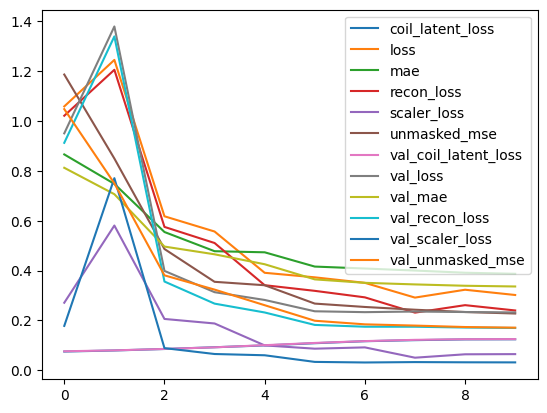

In [12]:
pd.DataFrame(history.history).plot()

In [4]:
import keras

In [ ]:
from transformers import SelfAttentionBlock, PoolingByMultiheadAttention
# encoder = tf.keras.models.load_model('coil_logs/20250812-152016_trial/encoder.keras', safe_mode=False)
encoder = tf.keras.models.load_model(
    "coil_logs/20250812-152016_trial/encoder.keras",
    custom_objects={"SelfAttentionBlock": SelfAttentionBlock, 
                    'PoolingByMultiheadAttention': PoolingByMultiheadAttention},
    safe_mode=False,
)

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {}}.

Exception encountered: Could not locate class 'SelfAttentionBlock'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'transformers', 'class_name': 'SelfAttentionBlock', 'config': {'name': 'self_attention_block', 'embed_dim': 64, 'num_heads': 4, 'ff_dim': 128, 'dropout': 0.03687998002549748, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 135746802653696}}, 'registered_name': 'SelfAttentionBlock', 'build_config': {'input_shape': [None, 442, 64]}, 'name': 'self_attention_block', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 442, 64], 'dtype': 'float32', 'keras_history': ['dense', 0, 0]}}], 'kwargs': {'mask': {'class_name': '__keras_tensor__', 'config': {'shape': [None, 442], 'dtype': 'float32', 'keras_history': ['concatenate', 0, 0]}}}}]}